In [1]:
from prody import *
import numpy as np
from pylab import *
%matplotlib inline
confProDy(auto_show=False)

@> ProDy is configured: auto_show=False


In [2]:
activeMonomer = parsePDB('3b3f_A_Nter_trimmed_noSAH.pdb', compressed=False)
inactiveMonomer = parsePDB('3b3j_clean_Nter_trimmed.pdb', compressed=False)
activeMonomer_calphas = activeMonomer.select('calpha')
inactiveMonomer_calphas = inactiveMonomer.select('calpha')

@> 2611 atoms and 1 coordinate set(s) were parsed in 0.12s.
@> 2611 atoms and 1 coordinate set(s) were parsed in 0.08s.


In [3]:
gnm_active = GNM('3b3f Active Monomer')
gnm_active.buildKirchhoff(activeMonomer_calphas)
gnm_active.calcModes(n_modes='all')

@> Kirchhoff was built in 0.07s.
@> 325 modes were calculated in 0.13s.


In [4]:
gnm_inactive = GNM('3b3f Inactive Monomer')
gnm_inactive.buildKirchhoff(inactiveMonomer_calphas)
gnm_inactive.calcModes(n_modes='all')

@> Kirchhoff was built in 0.09s.
@> 325 modes were calculated in 0.16s.


### 2. Calculate the normalized PRS matrix
The PRS matrix is then calculated from the covariance matrix from the GNM, which is symmetric and does not allow differentiation of sensors and effectors. We therefore normalize it by dividing each row by its diagonal element. This is handled by the function calcPerturbResponse, which also returns effectiveness and sensitivity profiles, which are the averages over the rows and columns of the normalized PRS matrix, respectively.

In [5]:
prs_mat_active, eff, sens = calcPerturbResponse(gnm_active)
prs_mat_inactive, eff_inactive, sens_inactive = calcPerturbResponse(gnm_inactive)
#These profiles can also be calculated during analysis steps as shown later.

### 4. Identifying the effectors and sensors, and making a figure
Effectors are the most effective residues whose perturbation has large effects on the structure and dynamics. Conversely, sensors are the most sensitive residues, which respond most strongly to perturbations of effectors and themselves undergo structural changes. We can identify these two sets of residues by (a) viewing the profiles as graphs and deciding upon a reasonable cutoff or (b) coloring residues by effectiveness and sensitivity on the structure and looking at them in a molecular graphics program. For the latter approach, we write the profiles into new PDB files in place of the b-factor or occupancy field.

#### a. Making graphs and plotting them alongside the matrix
This approach is implemented in the showPerturbResponse function. This function will calculate the PRS matrix (normalized covariance) as well as the effectiveness and sensitivity profiles. In order to do this, we provide a model from which the covariance matrix can be retrieved or calculated (in this case gnm). We also provide PRMT4_ca so that atom information can be used too.

@> WARNING matplotlib 3.6 and later are not compatible with interactive matrices
@> WARNING matplotlib 3.6 and later are not compatible with interactive matrices


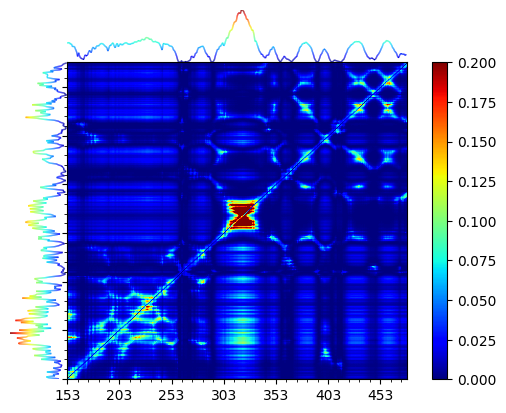

In [6]:
showPerturbResponse(prs_mat_active, atoms = activeMonomer_calphas, 
                    cmap=cm.jet, 
                    norm=Normalize(0,np.max(prs_mat_active)/5));

In [13]:
import numpy as np

# Assuming prs_mat_active is a numpy array and activeDimer_calphas is a list of Atom objects from ProDy
effectiveness_values = np.sum(prs_mat_active, axis=1)  # Summing across rows for each residue

# Get the number of residues that correspond to the top 10% of the sorted effectiveness values
top_percentage = 0.10  # This represents the top 10%
num_top_residues = int(len(effectiveness_values) * top_percentage)

# Sort the indices of effectiveness values in descending order
sorted_indices = np.argsort(effectiveness_values)[::-1]

# Select the top 10% of sorted indices
top_indices = sorted_indices[:num_top_residues]

# Print the residues with their effectiveness values
print(f"Top {int(top_percentage * 100)}% residues based on effectiveness (sorted):")
for idx in top_indices:
    residue_number = activeMonomer_calphas[idx].getResnum()  # Get the residue number from the Atom object
    effectiveness_value = effectiveness_values[idx]
    print(f"Residue: {residue_number}, Effectiveness: {effectiveness_value:.3f}")


Top 10% residues based on effectiveness (sorted):
Residue: 200, Effectiveness: 15.438
Residue: 213, Effectiveness: 14.080
Residue: 195, Effectiveness: 13.712
Residue: 190, Effectiveness: 13.262
Residue: 189, Effectiveness: 13.247
Residue: 203, Effectiveness: 13.173
Residue: 211, Effectiveness: 12.717
Residue: 214, Effectiveness: 12.456
Residue: 194, Effectiveness: 12.428
Residue: 236, Effectiveness: 12.372
Residue: 193, Effectiveness: 11.971
Residue: 191, Effectiveness: 11.938
Residue: 215, Effectiveness: 11.767
Residue: 314, Effectiveness: 11.583
Residue: 422, Effectiveness: 11.538
Residue: 196, Effectiveness: 11.320
Residue: 315, Effectiveness: 11.060
Residue: 223, Effectiveness: 11.036
Residue: 197, Effectiveness: 11.000
Residue: 331, Effectiveness: 10.920
Residue: 311, Effectiveness: 10.847
Residue: 220, Effectiveness: 10.738
Residue: 238, Effectiveness: 10.537
Residue: 328, Effectiveness: 10.486
Residue: 325, Effectiveness: 10.386
Residue: 192, Effectiveness: 10.244
Residue: 210, 

@> WARNING matplotlib 3.6 and later are not compatible with interactive matrices
@> WARNING matplotlib 3.6 and later are not compatible with interactive matrices


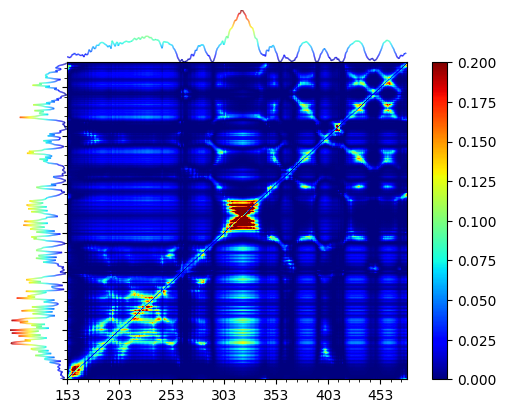

In [7]:
showPerturbResponse(prs_mat_inactive, atoms = inactiveMonomer_calphas, 
                    cmap=cm.jet,
                    norm=Normalize(0,np.max(prs_mat_inactive)/5));

The last two options make the matrix color map match the paper and normalize the scale to make weaker signals more apparent. There are usually a few very strong signals, which otherwise drown out everything else. The current choice of capping at 1/5 of the max value looks reasonable for seeing the structure of the matrix.

### 5. Plotting or visualizing effectiveness and sensitivity profiles
We can show the effectiveness and sensitivity profiles separately to aid in identifying the effectors and sensors, which would be the residues with the highest values for these quantities, respectively. This can be shown in a plot or on a structure.

a. Plotting profiles
We can plot profiles from showPerturbResponse by setting show_matrix=False. The default is to show the overall effectiveness and sensitivity profiles, which are the averages across the rows and columns. You can also select residues and show individual rows and columns corresponding to them as I will demonstrate later.

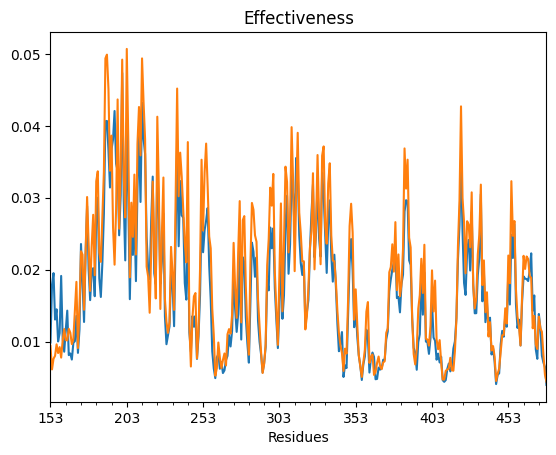

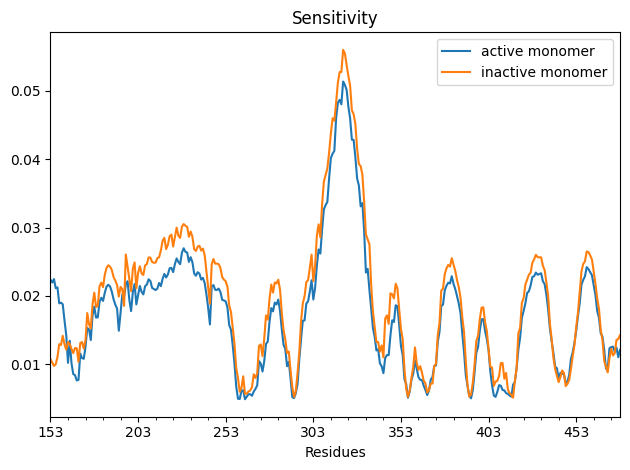

In [18]:
labels = "active monomer", "inactive monomer"
showPerturbResponse(prs_mat_active, atoms=activeMonomer_calphas, show_matrix=False, label = 'active monomer')
showPerturbResponse(prs_mat_inactive, atoms=inactiveMonomer_calphas, show_matrix=False, label = 'inactive monomer')
plt.legend(labels)
plt.tight_layout()
plt.show()

### b. Writing profiles to PDB files for visualization (Figures 6B-C)
In order to visualize profiles on the structure, we write new PDB files with these values in the beta-factor or occupancy column. This can be done on the all-atom structure by making use of the function extendAtomicData as follows:

In [9]:
# Flatten the effectiveness values if necessary
eff = eff.flatten()

# Get residue indices of c-alpha atoms
calpha_resindices = activeMonomer_calphas.getResindices()

# Create a dictionary mapping from residue index to effectiveness value
residue_eff_map = dict(zip(calpha_resindices, eff))

# Create an array to hold the effectiveness values for all atoms
eff_ext = np.zeros(activeMonomer.numAtoms())

# Assign effectiveness values to all atoms based on their residue
for i, resindex in enumerate(activeMonomer.getResindices()):
    if resindex in residue_eff_map:
        eff_ext[i] = residue_eff_map[resindex]

In [10]:
writePDB('3b3f_monomer_effectiveness.pdb', activeMonomer, beta=eff_ext)

'3b3f_monomer_effectiveness.pdb'

In [11]:
# Flatten the sensetivity values if necessary
sens = sens.flatten()

# Get residue indices of c-alpha atoms
calpha_resindices = activeMonomer_calphas.getResindices()

# Create a dictionary mapping from residue index to effectiveness value
residue_sens_map = dict(zip(calpha_resindices, sens))

# Create an array to hold the effectiveness values for all atoms
sens_ext = np.zeros(activeMonomer.numAtoms())

# Assign effectiveness values to all atoms based on their residue
for i, resindex in enumerate(activeMonomer.getResindices()):
    if resindex in residue_sens_map:
        sens_ext[i] = residue_sens_map[resindex]

In [12]:
writePDB('3b3f_monomer_sensetivity.pdb', activeMonomer, beta=sens_ext)

'3b3f_monomer_sensetivity.pdb'

In [13]:
# Flatten the effectiveness values if necessary
eff_inactive = eff_inactive.flatten()

# Get residue indices of c-alpha atoms
calpha_resindices_inactive = inactiveMonomer_calphas.getResindices()

# Create a dictionary mapping from residue index to effectiveness value
residue_eff_inactive_map = dict(zip(calpha_resindices_inactive, eff_inactive))

# Create an array to hold the effectiveness values for all atoms
eff_inactive_ext = np.zeros(inactiveMonomer.numAtoms())

# Assign effectiveness values to all atoms based on their residue
for i, resindex in enumerate(inactiveMonomer.getResindices()):
    if resindex in residue_eff_inactive_map:
        eff_inactive_ext[i] = residue_eff_inactive_map[resindex]

In [14]:
writePDB('3b3j_monomer_effectiveness.pdb', inactiveMonomer, beta=eff_inactive_ext)

'3b3j_monomer_effectiveness.pdb'

In [15]:
# Flatten the sensetivity values if necessary
sens_inactive = sens_inactive.flatten()

# Get residue indices of c-alpha atoms
calpha_resindices_inactive = inactiveMonomer_calphas.getResindices()

# Create a dictionary mapping from residue index to effectiveness value
residue_sens_inactive_map = dict(zip(calpha_resindices_inactive, sens_inactive))

# Create an array to hold the effectiveness values for all atoms
sens_inactive_ext = np.zeros(inactiveMonomer.numAtoms())

# Assign effectiveness values to all atoms based on their residue
for i, resindex in enumerate(inactiveMonomer.getResindices()):
    if resindex in residue_sens_inactive_map:
        sens_inactive_ext[i] = residue_sens_inactive_map[resindex]

In [16]:
writePDB('3b3j_monomer_sensetivity.pdb', inactiveMonomer, beta=sens_inactive_ext)

'3b3j_monomer_sensetivity.pdb'

To visualize this data, load the files into the graphics program of your choice and color by b-factor. In VMD, you would do this through the Graphical Representation window (from Graphics > Representations menu). The window that comes up gives various Color Method options from which you would pick Beta. The residues with high b-factor are shown in blue followed by white and ending at red for low b-factor. You can change this via the Color Controls window (Graphics > Color); this has a Color Scale tab with a Method dropdown from which you can pick other options.

## 5. Plotting or visualizing effectiveness and sensitivity profiles¶

To look at the effectiveness that perturbing a residue has in eliciting a response in individual residues (instead of its overall effectiveness) or to look at the sensitivity of a residue to perturbations of individual residues (instead of its overall sensitivity), we read out rows or columns from the perturbation response matrix.

### a. Plotting
For this purpose, use the showPerturbResponse function with the option show_matrix=False, which makes it create line graphs. By default this gives plots for the average effectiveness and sensitivity.

You can also show plots for individual residues by slicing out rows or columns of the PRS matrix. By default, a row is selected (axis=0), which corresponds to the effectiveness of the selected residue(s).

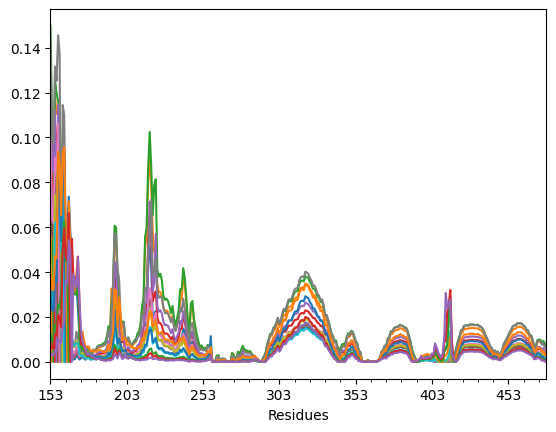

In [17]:
#effectiveness of residues 153-200
showPerturbResponse(prs_mat_active, atoms=activeMonomer_calphas, show_matrix=False,
                    select='resnum 153 to 167');

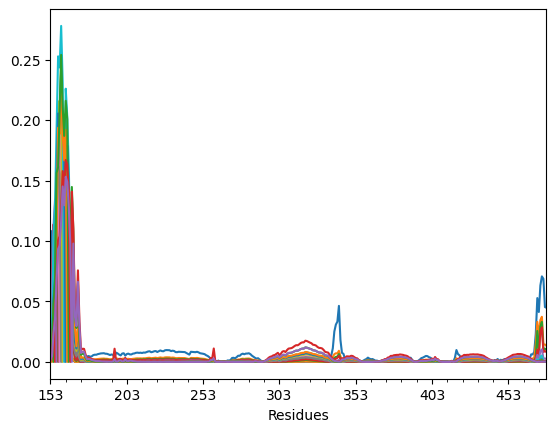

In [18]:
showPerturbResponse(prs_mat_inactive, atoms=inactiveMonomer_calphas, show_matrix=False,
                    select='resnum 153 to 167');

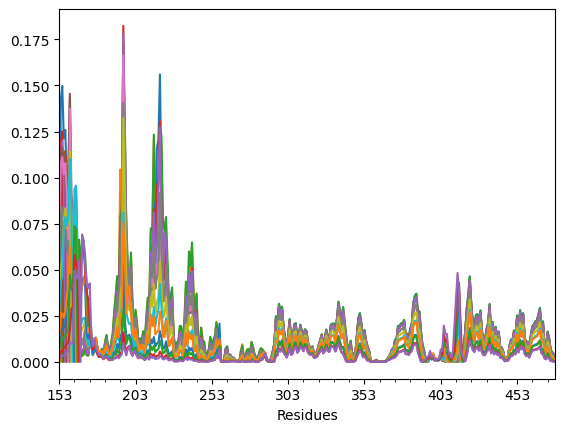

In [19]:
#sensetivity of residues 153-200
showPerturbResponse(prs_mat_active, atoms=activeMonomer_calphas, show_matrix=False,
                    select='resnum 153 to 167', axis=1);

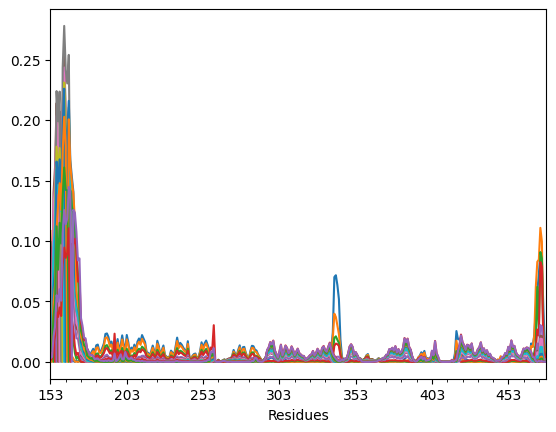

In [20]:
#sensetivity of residues 153-200
showPerturbResponse(prs_mat_inactive, atoms=inactiveMonomer_calphas, show_matrix=False,
                    select='resnum 153 to 167', axis=1);

To show individual plots, you can provide figure names or numbers as follows:

In [22]:
#for i, resnum in enumerate(range(153,200)):
#   showPerturbResponse(prs_mat_active, atoms=activeMonomer_calphas, show_matrix=False,
#                       select='resnum {0}'.format(resnum), figure=i);

In [23]:
#for i, resnum in enumerate(range(153,200)):
#    showPerturbResponse(prs_mat_inactive, atoms=inactiveMonomer_calphas, show_matrix=False,
#                        select='resnum {0}'.format(resnum), figure=i);

### b. Visualization
We can extract residue-specific profiles by slicing the PRS matrix with a residue selection using sliceAtomicData. We then use writePDB again.

We set axis=0 to read out a row from the PRS matrix, which is a residue-specific effectiveness profile. For example, you could use the following command:

In [24]:
Q155D156_effectiveness = sliceAtomicData(prs_mat_active, activeMonomer_calphas, 'resnum 155 to 156', 
                                     axis=0)

In [ ]:
writePDB('3b3f_Q155D156_eff_mono.pdb', activeMonomer_calphas, betas=Q155D156_effectiveness)

In [27]:
#selection = activeMonomer.select('resnum 155 to 156')
ext_Q155D156_effectiveness = extendAtomicData(Q155D156_effectiveness.flatten(), 
                                          activeMonomer_calphas, activeMonomer)

ValueError: data and nodes must have the same size

You can also ask for columns (axis=1) rather than rows to get residue-specific sensititivity:

In [ ]:
Q155D156_sensitivity = sliceAtomicData(prs_mat_active, activeMonomer_calphas, 'resnum 155 to 156', 
                                     axis=0)

In [ ]:
writePDB('3b3f_Q155D156_sensitivity_mono.pdb', activeMonomer_calphas, betas=Q155D156_sensitivity)

We can also extend the data to include all atoms using the function extendAtomicData as follows. We need to apply the flatten method of V397_sensitivity because it has two dimensions (one of them telling us that is just one row).

In [ ]:
V389_sensitivity.shape

In [ ]:
ext_V389_sensitivity = extendAtomicData(V389_sensitivity.flatten(), 
                                        hsp70_ca, selection)

In [ ]:
writePDB('4jne_aa_V389_col.pdb', selection, betas=ext_V389_sensitivity)

The same applies for V397_effectiveness where one of the two dimensions is telling us that is just one column.

In [ ]:
V389_effectiveness.shape

In [ ]:
ext_V389_effectiveness = extendAtomicData(V389_effectiveness.flatten(), 
                                          hsp70_ca, selection)

In [ ]:
writePDB('4jne_aa_V389_row.pdb', selection, betas=ext_V389_effectiveness)